In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

import gpder
from gpder import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel
from gpder.gaussian_process.kernels import DerivativeKernel
from gpder import GPUncertaintyOptimizer, NetVarianceLoss

In [2]:
def f(x):
    return x * np.cos(x)


def df(x):
    return np.cos(x) - x * np.sin(x)

In [3]:
X_lower, X_upper = -10, 10

# -- testing -- #
X_test = np.linspace(X_lower, X_upper, 100).reshape(-1, 1)
dX_test = X_test
y_test = f(X_test)
dy_test = df(dX_test)
# ------------- #

# -- training -- #
X_train = np.array([-2, 2, 5, 7.5]).reshape(-1, 1)
y_train = f(X_train)
dX_train = X_train
dy_train = df(dX_train)
# -------------- #

# Figure 1

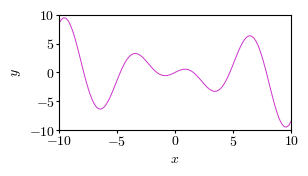

In [4]:
X_lower, X_upper = -10, 10

# -- testing -- #
X_test = np.linspace(X_lower, X_upper, 100).reshape(-1, 1)
dX_test = X_test
y_test = f(X_test)
dy_test = df(dX_test)
# ------------- #

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

ax.plot(X_test, y_test, zorder=1, color="m", alpha=0.8, linewidth=0.7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xticks([-10, -5, 0, 5, 10])
ax.tick_params(axis="both", which="major", length=2, pad=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

plt.savefig("toy1D_truth_reg.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)

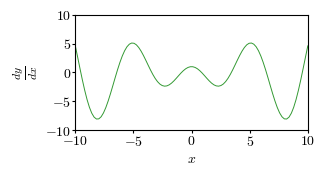

In [5]:
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

ax.plot(X_test, dy_test, zorder=1, color="g", alpha=0.8, linewidth=0.7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\frac{dy}{dx}$", fontsize=12)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.tick_params(axis="both", which="major", length=2, pad=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

plt.savefig("toy1D_truth_der.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)

# Figure 2 (a)

/home/alex/Desktop/gpder_MLST/gpder/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


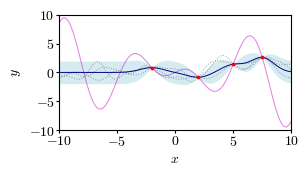

In [6]:
np.random.seed(45)

kernel = RegularKernel(amplitude=1, length_scale=1, noise_level=None)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_reg.fit(X_train, y_train)
y_pred_mean, y_pred_std = gp_reg.predict(X_test, return_std=True)
_, y_pred_cov = gp_reg.predict(X_test, return_cov=True)
samples = gp_reg.sample(X_test, n_draws=5, random_state=42)

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

lower_conf = y_pred_mean.ravel() - 1.96 * y_pred_std.ravel()
upper_conf = y_pred_mean.ravel() + 1.96 * y_pred_std.ravel()
ax.plot(X_test, y_pred_mean, zorder=3, color="navy", linewidth=0.7)
ax.fill_between(
    X_test.ravel(), lower_conf, upper_conf, zorder=1, color="lightblue", alpha=0.5, lw=0
)
samples = np.random.multivariate_normal(y_pred_mean.ravel(), y_pred_cov, 3)
for i, sample in enumerate(samples):
    ax.plot(X_test, sample, ls="dotted", zorder=2, color="gray", alpha=0.8, linewidth=0.7)
ax.scatter(X_train, y_train, marker="o", zorder=4, color="#FF0000", s=3)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xticks([-10, -5, 0, 5, 10])

ax.plot(X_test, y_test, zorder=1, color="m", alpha=0.5, linewidth=0.7)

ax.tick_params(axis="both", which="major", length=2, pad=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

plt.savefig("toy1D_initial_regGP.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)

# Figure 2 (b)

/home/alex/Desktop/gpder_MLST/gpder/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


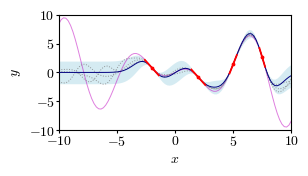

In [7]:
def yinline(x, m, b):
    return m * x + b


def xincircle(x0, y0, m, b, r):
    A = 1 + m**2
    B = 2 * (m * b - x0 - y0 * m)
    C = x0**2 + y0**2 + b**2 - 2 * y0 * b - r**2
    res_plus = (-B + np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    res_neg = (-B - np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    return np.array((res_plus, res_neg))


def xinelipse(x0, y0, m, b, rx, ry):
    A = 1 / rx**2 + m**2 / ry**2
    B = 2 * (m * (b - y0) / ry**2 - x0 / rx**2)
    C = x0**2 / rx**2 + (b - y0) ** 2 / ry**2 - 1
    res_plus = (-B + np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    res_neg = (-B - np.sqrt(B**2 - 4 * A * C)) / (2 * A)
    return np.array((res_plus, res_neg))


def get_gradients_xy(x, y, dy, length_x, length_y=None):
    b = y - dy * x
    if length_y is None:
        x_vals = xincircle(x, y, dy, b, length_x)
    else:
        x_vals = xinelipse(x, y, dy, b, length_x, length_y)
    y_vals = np.array([yinline(x_vals[0], dy, b), yinline(x_vals[1], dy, b)])
    return (x_vals, y_vals)


np.random.seed(45)

kernel = DerivativeKernel(amplitude=1, length_scale=1, noise_level=None, noise_level_der=None)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_der.fit(X_train, y_train, X_train, dy_train)
y_pred_mean, y_pred_std = gp_der.predict(X_test, return_std=True)
_, y_pred_cov = gp_der.predict(X_test, return_cov=True)

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

lower_conf = y_pred_mean.ravel() - 1.96 * y_pred_std.ravel()
upper_conf = y_pred_mean.ravel() + 1.96 * y_pred_std.ravel()
ax.plot(X_test, y_pred_mean, zorder=3, color="navy", linewidth=0.7)
ax.fill_between(
    X_test.ravel(), lower_conf, upper_conf, zorder=1, color="lightblue", alpha=0.5, lw=0
)

samples = np.random.multivariate_normal(y_pred_mean.ravel(), y_pred_cov, 3)
for i, sample in enumerate(samples):
    ax.plot(X_test, sample, ls="dotted", zorder=2, color="gray", alpha=0.8, linewidth=0.7)
ax.scatter(X_train, y_train, marker="o", zorder=4, color="#FF0000", s=3)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xticks([-10, -5, 0, 5, 10])

ax.plot(X_test, y_test, zorder=1, color="m", alpha=0.5, linewidth=0.7)

ax.tick_params(axis="both", which="major", length=2, pad=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

for x, y, dy in list(zip(X_train, y_train, dy_train)):
    x_vals, y_vals = get_gradients_xy(x, y, dy, 1, 1 * (5 / 3))
    ax.plot(x_vals, y_vals, color="#FF0000", zorder=5, linewidth=1.3)

plt.savefig("toy1D_initial_derGP.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)

# Figure 3 (a)

/home/alex/Desktop/gpder_MLST/gpder/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


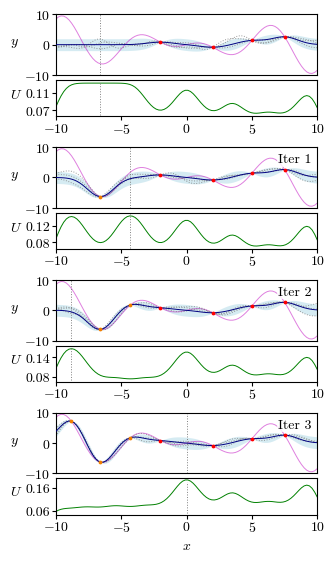

In [8]:
np.random.seed(45)

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)

n_plots = 4
# fig = plt.figure(n_plots, figsize=((3+3/8)/2, 11*0.76*(3/5)))
fig = plt.figure(n_plots, figsize=((3 + 3 / 8), 6.5))
outer_gs = gridspec.GridSpec(n_plots, 1)
ax = []
for i in range(n_plots):
    gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[i], hspace=0.1, height_ratios=[1, 0.6]
    )
    for cell in gs:
        ax.append(fig.add_subplot(cell))
plt.subplots_adjust(wspace=0.45, hspace=0.3)

kernel = RegularKernel(amplitude=1, length_scale=1, noise_level=None)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_reg.fit(X_train, y_train)

BED_reg = GPUncertaintyOptimizer(
    gp_model=gp_reg, bounds={"X": (X_lower, X_upper)}, function=f, random_state=42, verbose=False
)

# first panel is the initial GP
mean, std = gp_reg.predict(X_test, return_std=True)
_, cov = gp_reg.predict(X_test, return_cov=True)
mean, std = mean.ravel(), std.ravel()
uncert_band = 1.96 * std
ax[0].plot(X_test, mean, color="navy", linewidth=0.7, zorder=3)
ax[0].fill_between(
    X_test.ravel(),
    mean - uncert_band,
    mean + uncert_band,
    color="lightblue",
    alpha=0.5,
    zorder=1,
    lw=0,
)
samples = np.random.multivariate_normal(mean.ravel(), cov, 3)
for i, sample in enumerate(samples):
    ax[0].plot(X_test, sample, ls="dotted", zorder=2, color="gray", alpha=0.8, linewidth=0.7)
ax[0].scatter(X_train, y_train, marker="o", color="r", s=3, zorder=50)
last_mean, last_ucert_band = mean, uncert_band
props = dict(boxstyle="square", facecolor="white", alpha=0.8, pad=0.1, edgecolor="none")
# ax[0].text(-16, (np.max(mean)+np.min(mean))/2, "y", rotation='vertical')
ax[0].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)
ax[0].plot(X_test, y_test, zorder=1, color="m", alpha=0.5, linewidth=0.7)

ax[0].tick_params(axis="both", which="major", length=2, pad=1)
ax[0].get_xaxis().set_visible(False)
# ----- plot the utility function -------------------------------------- #
acq = NetVarianceLoss(gp_reg, X_test, norm=np.trace(cov))
utility = [acq.utility(X) for X in X_test]
ax[1].plot(X_test, utility, color="green", linewidth=0.7)
# ax[1].text(-16, np.min(utility)+(np.max(utility)-np.min(utility))*-0.1+0.02, "Utility", rotation='vertical')
ax[1].set_xlim(-10, 10)

ax[0].tick_params(axis="both", which="major", length=3, pad=1)
ax[1].tick_params(axis="both", which="major", length=3, pad=1)

ax[0].text(
    -13.5, np.mean([ax[0].get_ylim()[1], ax[0].get_ylim()[0]]), r"$y$", zorder=100, bbox=props
)
ax[1].text(
    -13.5, np.mean([ax[1].get_ylim()[1], ax[1].get_ylim()[0]]), r"$U$", zorder=100, bbox=props
)
ax[1].set_yticks([ax[1].get_ylim()[0] * 1.2, ax[1].get_ylim()[1] * 0.8])
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

for i in range(1, n_plots):
    gp_reg = BED_reg.minimize_variance(
        X_util=X_test, n_iters=1, n_restarts_optimizer=5, added_noise=None
    )
    # ----- plot the prediction -------------------------------------------- #
    mean, std = gp_reg.predict(X_test, return_std=True)
    _, cov = gp_reg.predict(X_test, return_cov=True)
    mean, std = mean.ravel(), std.ravel()
    uncert_band = 1.96 * std
    ax[i * 2].plot(X_test, mean, color="navy", linewidth=0.7, zorder=3)
    ax[i * 2].fill_between(
        X_test.ravel(),
        mean - uncert_band,
        mean + uncert_band,
        color="lightblue",
        alpha=0.5,
        zorder=1,
        lw=0,
    )
    samples = np.random.multivariate_normal(mean.ravel(), cov, 3)
    for j, sample in enumerate(samples):
        ax[i * 2].plot(
            X_test, sample, ls="dotted", zorder=2, color="gray", alpha=0.8, linewidth=0.7
        )
    ax[i * 2].scatter(gp_reg.X_train[:4], gp_reg.y_train[:4], marker="o", color="r", s=3, zorder=50)
    ax[i * 2].scatter(
        gp_reg.X_train[4:], gp_reg.y_train[4:], marker="o", color="#F17E00", s=3, zorder=50
    )
    ax[i * 2].set_xlim(-10, 10)
    ax[i * 2].set_ylim(-10, 10)
    ax[i * 2].set_xticks([-10, -5, 0, 5, 10])
    ax[i * 2].tick_params(axis="both", which="major", length=2, pad=1)
    ax[i * 2].get_xaxis().set_visible(False)
    ax[i * 2].plot(X_test, y_test, zorder=1, color="m", alpha=0.5, linewidth=0.7)
    # ----- plot the utility function -------------------------------------- #
    acq = NetVarianceLoss(gp_reg, X_test, norm=np.trace(cov))
    utility = [acq.utility(X) for X in X_test]
    ax[i * 2 + 1].plot(X_test, utility, color="green", linewidth=0.7)
    ax[i * 2 + 1].set_xlim(-10, 10)
    # ----- next sampling point -------------------------------------------- #
    X_last = gp_reg.X_train[-1]
    ax[i * 2 - 2].vlines(
        X_last,
        ax[i * 2 - 2].get_ylim()[0],
        ax[i * 2 - 2].get_ylim()[1],
        linestyle="dotted",
        linewidth=0.7,
        color="gray",
    )
    ax[i * 2 - 1].vlines(
        X_last,
        ax[i * 2 - 1].get_ylim()[0],
        ax[i * 2 - 1].get_ylim()[1],
        linestyle="dotted",
        linewidth=0.7,
        color="gray",
    )
    last_mean, last_ucert_band = mean, uncert_band

    ax[i * 2].tick_params(axis="both", which="major", length=3, pad=1)
    ax[i * 2 + 1].tick_params(axis="both", which="major", length=3, pad=1)

    ax[i * 2].text(
        -13.5,
        np.mean([ax[i * 2].get_ylim()[1], ax[i * 2].get_ylim()[0]]),
        r"$y$",
        zorder=100,
        bbox=props,
    )
    ax[i * 2 + 1].text(
        -13.5,
        np.mean([ax[i * 2 + 1].get_ylim()[1], ax[i * 2 + 1].get_ylim()[0]]),
        r"$U$",
        zorder=100,
        bbox=props,
    )
    ax[i * 2 + 1].set_yticks([ax[i * 2 + 1].get_ylim()[0] * 1.2, ax[i * 2 + 1].get_ylim()[1] * 0.8])
    ax[i * 2 + 1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))


gp_reg = BED_reg.minimize_variance(
    X_util=X_test, n_iters=1, n_restarts_optimizer=5, added_noise=None
)
X_last = gp_reg.X_train[-1]
ax[-2].vlines(
    X_last,
    ax[-2].get_ylim()[0],
    ax[-2].get_ylim()[1],
    linestyle="dotted",
    linewidth=0.7,
    color="gray",
)
ax[-1].vlines(
    X_last,
    ax[-1].get_ylim()[0],
    ax[i * 2 - 1].get_ylim()[1],
    linestyle="dotted",
    linewidth=0.7,
    color="gray",
)

props = dict(boxstyle="square", facecolor="white", alpha=0.8, pad=0.1, edgecolor="none")
ax[2].text(7, 5, "Iter 1", zorder=100, bbox=props)
ax[4].text(7, 5, "Iter 2", zorder=100, bbox=props)
ax[6].text(7, 5, "Iter 3", zorder=100, bbox=props)
ax[-1].set_xlabel(r"$x$")

plt.savefig("toy1D_BED_regGP.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)

# Figure 3 (b)

/home/alex/Desktop/gpder_MLST/gpder/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


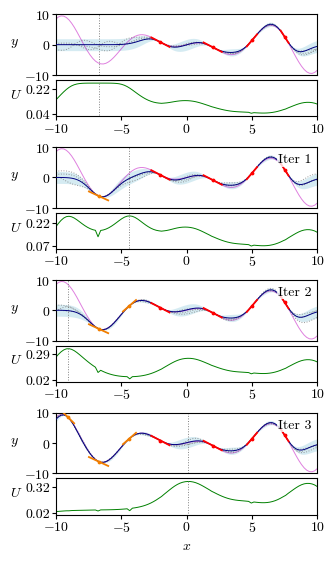

In [9]:
np.random.seed(45)

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)

n_plots = 4
fig = plt.figure(n_plots, figsize=((3 + 3 / 8), 6.5))
outer_gs = gridspec.GridSpec(n_plots, 1)
ax = []
for i in range(n_plots):
    gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[i], hspace=0.1, height_ratios=[1, 0.6]
    )
    for cell in gs:
        ax.append(fig.add_subplot(cell))
plt.subplots_adjust(wspace=0.45, hspace=0.3)

kernel = DerivativeKernel(amplitude=1, length_scale=1, noise_level=None, noise_level_der=None)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gp_der.fit(X_train, y_train, X_train, dy_train)

BED_der = GPUncertaintyOptimizer(
    gp_model=gp_der,
    bounds={"X": (X_lower, X_upper)},
    function=f,
    der_function=df,
    random_state=42,
    verbose=False,
)

# first panel is the initial GP
mean, std = gp_der.predict(X_test, return_std=True)
_, cov = gp_der.predict(X_test, return_cov=True)
mean, std = mean.ravel(), std.ravel()
uncert_band = 1.96 * std
ax[0].plot(X_test, mean, color="navy", linewidth=0.7, zorder=3)
ax[0].fill_between(
    X_test.ravel(),
    mean - uncert_band,
    mean + uncert_band,
    color="lightblue",
    alpha=0.5,
    zorder=1,
    lw=0,
)
samples = np.random.multivariate_normal(mean.ravel(), cov, 3)
for i, sample in enumerate(samples):
    ax[0].plot(X_test, sample, ls="dotted", zorder=2, color="gray", alpha=0.8, linewidth=0.7)
ax[0].scatter(X_train, y_train, marker="o", color="r", s=3, zorder=50)
last_mean, last_ucert_band = mean, uncert_band
props = dict(boxstyle="square", facecolor="white", alpha=0.8, pad=0.1, edgecolor="none")
ax[0].set_xlim(-10, 10)
ax[0].tick_params(axis="both", which="major", length=2, pad=1)
ax[0].get_xaxis().set_visible(False)
# ----- plot the utility function -------------------------------------- #
acq = NetVarianceLoss(gp_der, X_test, norm=np.trace(cov))
utility = [acq.utility(X) for X in X_test]
ax[1].plot(X_test, utility, color="green", linewidth=0.7)
ax[1].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)
ax[0].plot(X_test, y_test, zorder=1, color="m", alpha=0.5, linewidth=0.7)

for x, y, dy in list(zip(gp_der.X_train[:4], gp_der.y_train[:4], gp_der.dy_train[:4])):
    x_vals, y_vals = get_gradients_xy(x, y, dy, 1, 1.3 * (5 / 3))
    ax[0].plot(x_vals[:4], y_vals[:4], color="#FF0000", zorder=5, linewidth=1.3)
for x, y, dy in list(zip(gp_der.X_train[4:], gp_der.y_train[4:], gp_der.dy_train[4:])):
    x_vals, y_vals = get_gradients_xy(x, y, dy, 1, 1.3 * (5 / 3))
    ax[0].plot(x_vals[:4], y_vals[:4], color="#F17E00", zorder=5, linewidth=1.3)

ax[0].tick_params(axis="both", which="major", length=3, pad=1)
ax[1].tick_params(axis="both", which="major", length=3, pad=1)

ax[0].text(
    -13.5, np.mean([ax[0].get_ylim()[1], ax[0].get_ylim()[0]]), r"$y$", zorder=100, bbox=props
)
ax[1].text(
    -13.5, np.mean([ax[1].get_ylim()[1], ax[1].get_ylim()[0]]), r"$U$", zorder=100, bbox=props
)
ax[1].set_yticks([ax[1].get_ylim()[0] * 1.2, ax[1].get_ylim()[1] * 0.8])
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

for i in range(1, n_plots):
    gp_der = BED_der.minimize_variance(
        X_util=X_test, n_iters=1, n_restarts_optimizer=5, added_noise=None
    )
    # ----- plot the prediction -------------------------------------------- #
    mean, std = gp_der.predict(X_test, return_std=True)
    _, cov = gp_der.predict(X_test, return_cov=True)
    mean, std = mean.ravel(), std.ravel()
    uncert_band = 1.96 * std
    ax[i * 2].plot(X_test, mean, color="navy", linewidth=0.7, zorder=3)
    ax[i * 2].fill_between(
        X_test.ravel(),
        mean - uncert_band,
        mean + uncert_band,
        color="lightblue",
        alpha=0.5,
        zorder=1,
        lw=0,
    )
    samples = np.random.multivariate_normal(mean.ravel(), cov, 3)
    for j, sample in enumerate(samples):
        ax[i * 2].plot(
            X_test, sample, ls="dotted", zorder=2, color="gray", alpha=0.8, linewidth=0.7
        )
    ax[i * 2].scatter(gp_der.X_train[:4], gp_der.y_train[:4], marker="o", color="r", s=3, zorder=50)
    ax[i * 2].scatter(
        gp_der.X_train[4:], gp_der.y_train[4:], marker="o", color="#F17E00", s=3, zorder=50
    )
    ax[i * 2].set_xlim(-10, 10)
    ax[i * 2].set_ylim(-10, 10)
    ax[i * 2].set_xticks([-10, -5, 0, 5, 10])
    ax[i * 2].tick_params(axis="both", which="major", length=2, pad=1)
    ax[i * 2].get_xaxis().set_visible(False)
    ax[i * 2].plot(X_test, y_test, zorder=1, color="m", alpha=0.5, linewidth=0.7)
    # ----- plot the utility function -------------------------------------- #
    acq = NetVarianceLoss(gp_der, X_test, norm=np.trace(cov))
    utility = [acq.utility(X) for X in X_test]
    ax[i * 2 + 1].plot(X_test, utility, color="green", linewidth=0.7)
    ax[i * 2 + 1].set_xlim(-10, 10)
    # ----- next sampling point -------------------------------------------- #
    X_last = gp_der.X_train[-1]
    ax[i * 2 - 2].vlines(
        X_last,
        ax[i * 2 - 2].get_ylim()[0],
        ax[i * 2 - 2].get_ylim()[1],
        linestyle="dotted",
        linewidth=0.7,
        color="gray",
    )
    ax[i * 2 - 1].vlines(
        X_last,
        ax[i * 2 - 1].get_ylim()[0],
        ax[i * 2 - 1].get_ylim()[1],
        linestyle="dotted",
        linewidth=0.7,
        color="gray",
    )
    last_mean, last_ucert_band = mean, uncert_band

    for x, y, dy in list(zip(gp_der.X_train[:4], gp_der.y_train[:4], gp_der.dy_train[:4])):
        x_vals, y_vals = get_gradients_xy(x, y, dy, 1, 1.3 * (5 / 3))
        ax[i * 2].plot(x_vals[:4], y_vals[:4], color="#FF0000", zorder=5, linewidth=1.3)
    for x, y, dy in list(zip(gp_der.X_train[4:], gp_der.y_train[4:], gp_der.dy_train[4:])):
        x_vals, y_vals = get_gradients_xy(x, y, dy, 1, 1.3 * (5 / 3))
        ax[i * 2].plot(x_vals[:4], y_vals[:4], color="#F17E00", zorder=5, linewidth=1.3)

    ax[i * 2].tick_params(axis="both", which="major", length=3, pad=1)
    ax[i * 2 + 1].tick_params(axis="both", which="major", length=3, pad=1)

    ax[i * 2].text(
        -13.5,
        np.mean([ax[i * 2].get_ylim()[1], ax[i * 2].get_ylim()[0]]),
        r"$y$",
        zorder=100,
        bbox=props,
    )
    ax[i * 2 + 1].text(
        -13.5,
        np.mean([ax[i * 2 + 1].get_ylim()[1], ax[i * 2 + 1].get_ylim()[0]]),
        r"$U$",
        zorder=100,
        bbox=props,
    )
    ax[i * 2 + 1].set_yticks([ax[i * 2 + 1].get_ylim()[0] * 1.2, ax[i * 2 + 1].get_ylim()[1] * 0.8])
    ax[i * 2 + 1].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))


gp_der = BED_der.minimize_variance(
    X_util=X_test, n_iters=1, n_restarts_optimizer=5, added_noise=None
)
X_last = gp_der.X_train[-1]
ax[-2].vlines(
    X_last,
    ax[-2].get_ylim()[0],
    ax[-2].get_ylim()[1],
    linestyle="dotted",
    linewidth=0.7,
    color="gray",
)
ax[-1].vlines(
    X_last,
    ax[-1].get_ylim()[0],
    ax[-1].get_ylim()[1],
    linestyle="dotted",
    linewidth=0.7,
    color="gray",
)

props = dict(boxstyle="square", facecolor="white", alpha=0.8, pad=0.1, edgecolor="none")
ax[2].text(7, 5, "Iter 1", zorder=100, bbox=props)
ax[4].text(7, 5, "Iter 2", zorder=100, bbox=props)
ax[6].text(7, 5, "Iter 3", zorder=100, bbox=props)
ax[-1].set_xlabel(r"$x$")

plt.savefig("toy1D_BED_derGP.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)

# Figure 4

In [10]:
def calculate_mse_var(gp, X_test, y_test, batch_size=268):
    n_batches = int(np.ceil(len(y_test) / batch_size))
    pred = np.zeros(len(y_test))
    trace_cov = 0.0
    for i in range(n_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        y_pred_mean, cov = gp.predict(X_test[start:end], return_cov=True)
        pred[start:end] = y_pred_mean.ravel()
        trace_cov += np.trace(cov)
    mse = np.mean((pred - y_test.ravel()) ** 2)
    return mse, trace_cov

In [11]:
mse_reg = np.zeros((10, 21))
trace_cov_reg = np.zeros((10, 21))

for i in range(10):
    kernel = RegularKernel(amplitude=1, length_scale=1, noise_level=None)
    gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    gp_reg.fit(X_train, y_train)

    mse, trace_cov = calculate_mse_var(gp_reg, X_test, y_test)
    mse_reg[i, 0] = mse
    trace_cov_reg[i, 0] = trace_cov

    BED_reg = GPUncertaintyOptimizer(
        gp_model=gp_reg,
        bounds={"X": (X_lower, X_upper)},
        function=f,
        random_state=42 + i,
        verbose=False,
    )

    for j in range(20):
        gp_reg = BED_reg.minimize_variance(
            X_util=X_test, n_iters=1, n_restarts_optimizer=5, added_noise=None
        )
        mse, trace_cov = calculate_mse_var(gp_reg, X_test, y_test)
        mse_reg[i, j + 1] = mse
        trace_cov_reg[i, j + 1] = trace_cov

/home/alex/Desktop/gpder_MLST/gpder/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


In [12]:
# 21 mins
mse_der = np.zeros((10, 21))
trace_cov_der = np.zeros((10, 21))

for i in range(10):
    kernel = DerivativeKernel(amplitude=1, length_scale=1, noise_level=None, noise_level_der=None)
    gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    gp_der.fit(X_train, y_train, X_train, dy_train)

    mse, trace_cov = calculate_mse_var(gp_der, X_test, y_test)
    mse_der[i, 0] = mse
    trace_cov_der[i, 0] = trace_cov

    BED_der = GPUncertaintyOptimizer(
        gp_model=gp_der,
        bounds={"X": (X_lower, X_upper)},
        function=f,
        der_function=df,
        random_state=42 + i,
        verbose=False,
    )

    for j in range(20):
        gp_der = BED_der.minimize_variance(
            X_util=X_test, n_iters=1, n_restarts_optimizer=5, added_noise=None
        )
        mse, trace_cov = calculate_mse_var(gp_der, X_test, y_test)
        mse_der[i, j + 1] = mse
        trace_cov_der[i, j + 1] = trace_cov

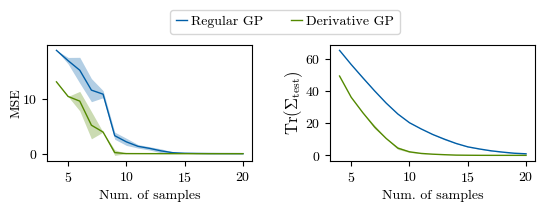

In [13]:
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 10,
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
    }
)
# fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
fig, ax = plt.subplots(1, 2, figsize=(6.3, 1.5))
plt.subplots_adjust(wspace=0.38)

iters = np.arange(4, 21)
ax[0].plot(
    iters,
    np.mean(mse_reg[:, :17], axis=0),
    label="Regular GP",
    color="#005EA7",
    zorder=5,
    linewidth=1,
)
ax[0].fill_between(
    iters,
    np.mean(mse_reg[:, :17], axis=0) - np.std(mse_reg[:, :17], axis=0),
    np.mean(mse_reg[:, :17], axis=0) + np.std(mse_reg[:, :17], axis=0),
    color="#005EA7",
    alpha=0.3,
    zorder=5,
    lw=0,
)
ax[0].plot(
    iters,
    np.mean(mse_der[:, :17], axis=0),
    label="Derivative GP",
    color="#538900",
    zorder=5,
    linewidth=1,
)
ax[0].fill_between(
    iters,
    np.mean(mse_der[:, :17], axis=0) - np.std(mse_der[:, :17], axis=0),
    np.mean(mse_der[:, :17], axis=0) + np.std(mse_der[:, :17], axis=0),
    color="#538900",
    alpha=0.3,
    zorder=5,
    lw=0,
)
ax[0].set_xlabel("Num. of samples", fontsize=10)
ax[0].set_ylabel("MSE", labelpad=0)
ax[0].set_xticks([5, 10, 15, 20])

ax[1].plot(
    iters,
    np.mean(trace_cov_reg[:, :17], axis=0),
    label="Regular GP",
    color="#005EA7",
    zorder=5,
    linewidth=1,
)
ax[1].fill_between(
    iters,
    np.mean(trace_cov_reg[:, :17], axis=0) - np.std(trace_cov_reg[:, :17], axis=0),
    np.mean(trace_cov_reg[:, :17], axis=0) + np.std(trace_cov_reg[:, :17], axis=0),
    color="#005EA7",
    alpha=0.3,
    zorder=5,
    lw=0,
)
ax[1].plot(
    iters,
    np.mean(trace_cov_der[:, :17], axis=0),
    label="Derivative GP",
    color="#538900",
    zorder=5,
    linewidth=1,
)
ax[1].fill_between(
    iters,
    np.mean(trace_cov_der[:, :17], axis=0) - np.std(trace_cov_der[:, :17], axis=0),
    np.mean(trace_cov_der[:, :17], axis=0) + np.std(trace_cov_der[:, :17], axis=0),
    color="#538900",
    alpha=0.3,
    zorder=5,
    lw=0,
)
ax[1].set_xlabel("Num. of samples", fontsize=10)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=0, fontsize=12)
ax[1].set_xticks([5, 10, 15, 20])

ax[0].legend(handlelength=0.8, ncol=2, labelspacing=0.3, handletextpad=0.3, loc=(0.6, 1.1))

plt.savefig("toy1D_BED_reg_vs_der.pdf", bbox_inches="tight", pad_inches=0.01, dpi=400)